# 2. Data Exploration
#### Juan Julián Cea Morán

![img](../images/ea.png)

---
The first step in every data science and research project involves understanding the data. This is crucial because the rest of the processing pipeline will depend on how good this understanding is.

As we saw in the introduction, the data corresponds to a subset of the data from this github repository https://www.researchgate.net/publication/301861882_A_Multilingual_Multi-Style_and_Multi-Granularity_Dataset_for_Cross-Language_Textual_Similarity_Detection a

Now, let's start by importing the data.


### Import data
The first step is to load the data into a pandas dataframe. For doing that, we will be using python walk functionality, which allows us to recursively traverse our target directory.

In [6]:
%%time
import pandas as pd
from os import walk

docs_df = pd.DataFrame(columns=['Name', 'Text', 'Lang', 'Category'])

cat = None
lang = None
for root, dirs, files in os.walk("../data/documents_challenge/", topdown=True):
    for _dir in dirs:
        cat = _dir
        for root2, dirs2, files2 in os.walk(os.path.join(root, _dir)):
            for _dir2 in dirs2:
                lang = _dir2
                for root3, dirs3, files3 in os.walk(os.path.join(root2, _dir2)):
                    for file in files3:
                        f = open(os.path.join(root3, file), 'r', encoding='utf-8')
                        docs_df.loc[docs_df.shape[0]] = [file, f.read(), lang, cat]
                        f.close()

    break

Wall time: 3min 20s


In [7]:
docs_df.head()

,Name,Text,Lang,Category
0,apr-book-0-en.txt,"i read this book because in my town, everyone ...",en,APR
1,apr-book-1-en.txt,recipes appreciated by the family (small and l...,en,APR
2,apr-book-10-en.txt,i say no to ease ..... and not to the author w...,en,APR
3,apr-book-100-en.txt,milady has found a good vein: anita blake. bas...,en,APR
4,apr-book-1000-en.txt,"460 bc, somewhere in greece: ""gentlemen, i dec...",en,APR


---
### Dataset information

Now that we have the data ready, it's time to explore the dataset properties.

In [15]:
print('Longitud: ' + str(len(docs_df)) + " samples")
print('Categories: ' + ', '.join(docs_df['Category'].unique()))
print('Languages: ' + ', '.join(docs_df['Lang'].unique()) + '\n')

Longitud: 23128 samples
Categories: APR, Conference_papers, PAN11, Wikipedia
Languages: en, fr, es



As we can see, there are 23128 samples in the corpus. There are 4 different categories and 3 diferent languages.

It is also convenient to check if there is any null or empty entry on the data. We are going to use pandas functions for check this info out.

In [16]:
docs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23128 entries, 0 to 23127
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      23128 non-null  object
 1   Text      23128 non-null  object
 2   Lang      23128 non-null  object
 3   Category  23128 non-null  object
dtypes: object(4)
memory usage: 903.4+ KB


In [17]:
docs_df.describe()

,Name,Text,Lang,Category
count,23128,23128,23128,23128
unique,23128,23012,3,4
top,pan-92-12-es.txt,translation not available,en,Wikipedia
freq,1,13,9724,13588


The first table tells us that there is no any empty value in any of the columns defined, so every sample has all the columns filled.

Regarding the second table, we can see that there are 166 duplicate text entries, so it would be necessary to remove them if this increases the performance. Before that, let's see those texts.

In [19]:
docs_df[docs_df.duplicated(subset=('Text'), keep='first')]

,Name,Text,Lang,Category
132,apr-book-1192-en.txt,translation not available,en,APR
319,apr-book-1472-en.txt,"disappointed by flaubert, it is somewhat prete...",en,APR
370,apr-book-1550-en.txt,"if you want an opinion on evolution, it is rea...",en,APR
404,apr-book-1600-en.txt,what a disappointment. the awards received by ...,en,APR
638,apr-book-1952-en.txt,"they told me 'you see, it's great, there's no ...",en,APR
...,...,...,...,...
8233,pan-75-0-en.txt,Metebaza! ... Fea! ... Feona! ... Chula! ...\...,en,PAN11
8897,pan-228-6-es.txt,"Volvió a los dos meses, muerto de hambre, mal...",es,PAN11
9148,pan-285-3-es.txt,"(N. de la E.)\n\n[32] Nochebuena chiquita, as...",es,PAN11
9410,pan-63-3-es.txt,"La hermosa canción, que canta Margarita mientr...",es,PAN11


We are going to drop every duplicated texts.

However, we can see that the firs entry sais: "translation not available". This give us information about what APR reviews are and also tell us that in this case, we don't one one copy of that text in the dataset.

In [22]:
docs_df.drop_duplicates(subset=('Text'), keep='first', inplace=True)

In [28]:
docs_df = docs_df[docs_df['Text'] != 'translation not available']

---
### Get some insights

Now is time to study the data so we can learn from it before making any further step.

Let's start by plotting the dataset information, so we can see how data is distributed.

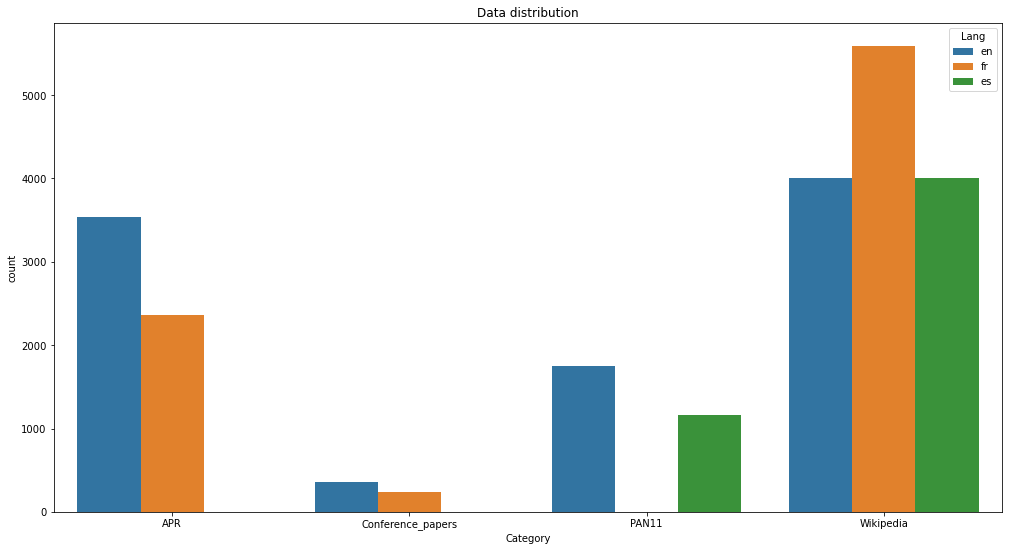

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.figure(figsize=(17,9));
sns.countplot(x="Category", hue="Lang", data=docs_df);
plt.title("Data distribution");

Regarding this plot, we can conclude that there are several diferences between categories. In case of APR, the amount of english documents is higher than the amount of french texts. This is the same for Conference_papers. In the case of PAN11 documents, there are also a slightly diference between english and spanish text. The main diference can be observed at Wikipedia texts, where we can find that english and spanish appears in quite similar quantity, but french documents has more representation. 

Another interesting insight is that only the Wikipedia category contains texts in all the three languages.

We can also see that Wikipedia is the most populated Category, while Conference_papers is the less populated one.

Let's finish this analysis by generating some wordclouds. This type of representation give us an intuition of what words are more relevant in the data (more occurrences). For doing that, we are going to use wordcloud package.

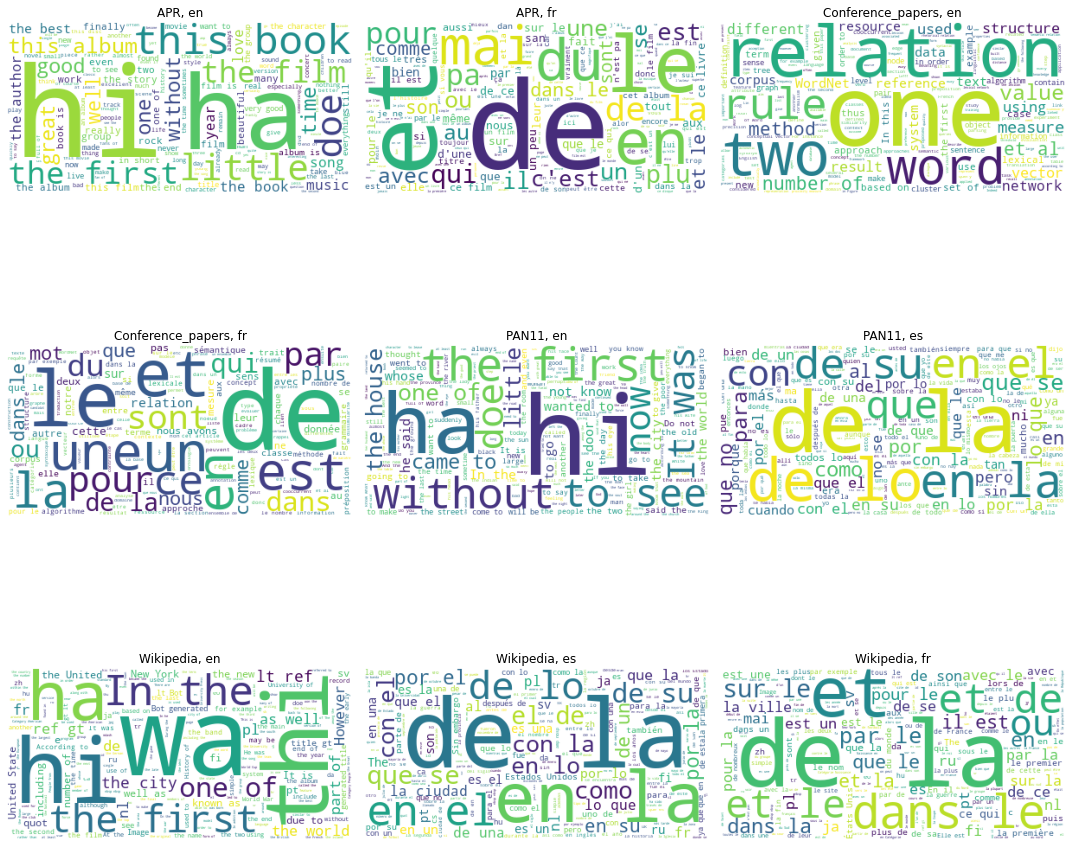

In [34]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

idx = 0

fig = plt.figure(figsize=(15, 15))

for cat in docs_df['Category'].unique():
    aux = docs_df[docs_df['Category'] == cat]
    for lang in aux['Lang'].unique():
        texts = aux[aux['Lang'] == lang]['Text']
        
        wordcloud = WordCloud(background_color="white").generate(' '.join(texts))
        
        idx += 1
        
        plt.subplot(3, 3, idx)
        plt.title(f"{cat}, {lang}")
        plt.imshow(wordcloud)
        plt.axis('off')

fig.tight_layout()

As we can see, the generated wordclouds give use information about each language for each context. We can see how the most repeated words are stop words. Those words has no relevant semantic information, so it would make our models to perform really bad. In the next notebook, we will take care of all those noisy terms before feeding the text into our models.

---

At last, we have to export the data

In [35]:
import pickle

output = open('../data/docs_df.pkl', 'wb')
pickle.dump (docs_df, output)
output.close()